# LSTM Model — Emission Point Classification with Optimization and Cross-Validation

This notebook develops an optimized Long Short-Term Memory (LSTM) model to classify particle emission points (E1, E2, E3) based on sequential sensor readings from simulated industrial environments. Unlike previous architectures (MLP and CNN), this LSTM pipeline integrates hyperparameter tuning and cross-validation to rigorously explore model performance and generalization.

---

## 🧠 Objectives

- Build a deep learning model using LSTM layers to handle time-dependent input sequences;
- Tune model architecture and training parameters using KerasTuner;
- Apply stratified K-fold cross-validation to ensure robust performance estimates;
- Apply proper scientific methodology to evaluate model performance, ensuring no data leakage between simulations;
- Evaluate final model performance on a held-out generalization set;
- Provide a scientific comparison against CNN and MLP baselines.

---

## 📁 Data Structure and Considerations

- **Input Data**: `dataset_timeseries.csv` — each row represents a flattened time window of sensor data with its emission class;
- **Reshaping**:  Features are reshaped into 3D format for LSTM (samples, time steps, sensors);
- **Normalization**: StandardScaler is applied only to the training folds during CV, avoiding data leakage;
- **Target Variable**: The emission class — `E1`, `E2`, or `E3`.

---

## ✅ Notebook Structure

1. Setup, Imports, and Random Seed Configuration;
2. Load and Preprocess Time-Series Dataset;
3. Prepare LSTM-Compatible Input Tensors;
4. Stratified K-Fold Cross-Validation Setup;
5. Define LSTM Model Builder for Tuning;
6. Hyperparameter Optimization with Keras Tuner;
7. Retrain Best Model on Full Training Set;
8. Final Evaluation on Generalization Test Set;
9. Visualization and Metric Reporting;
10. Scientific Summary and Model Saving.

---

> ⚠️ All experiments follow good machine learning practices, including stratified splitting, fold-wise normalization, and testing on unseen data for generalization.


### 0. Setup, Imports, and GPU Configuration

This initial cell prepares the development environment for building and tuning the LSTM model. It begins by importing all necessary libraries for data manipulation, modeling, evaluation, and hyperparameter optimization. To ensure experimental reproducibility, we fix random seeds for Python, NumPy, and TensorFlow. We also configure TensorFlow to detect and utilize the GPU, if available, while limiting GPU memory allocation to avoid resource exhaustion — especially important during hyperparameter tuning. This setup ensures consistency, performance, and scientific rigor for the remainder of the notebook.

In [1]:
# Setup, Imports, and Random Seed Configuration

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    cohen_kappa_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Keras Tuner
import keras_tuner as kt

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU Configuration (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth instead of allocating all at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration failed: {e}")
else:
    print("⚠️ No GPU detected — using CPU.")

# Versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")
print(f"Pandas version:     {pd.__version__}")

✅ Using GPU: /physical_device:GPU:0
TensorFlow version: 2.10.0
NumPy version:      1.26.4
Pandas version:     2.2.3


### 1. Load and Preprocess Time-Series Dataset

In this step, we load the processed time-series dataset generated in the previous pipeline. The dataset contains flattened sensor readings organized in windows, each labeled with an emission class (E1, E2, or E3). We reshape the input features into a 3D tensor suitable for LSTM models:  
**(samples, timesteps, sensors)**. The target labels are encoded from categorical strings to one-hot vectors for use in categorical classification. This prepares the dataset for stratified splitting and modeling.

In [2]:
# Load the preprocessed windowed dataset
df = pd.read_csv('../data/processed/timeseries_dataset.csv')

# Separate features (all columns except 'classe') and labels
X_flat = df.drop(columns=['classe']).values
y_raw  = df['classe'].values

# Define window size and compute number of sensors
WINDOW_SIZE = 30  # must match the generation script
n_features  = X_flat.shape[1]
n_sensors   = n_features // WINDOW_SIZE

# Reshape flattened windows to 3D format: (samples, timesteps, sensors)
X = X_flat.reshape(-1, WINDOW_SIZE, n_sensors)

# Encode labels: string → integer → one-hot
le = LabelEncoder()
y_int = le.fit_transform(y_raw)        # E1 → 0, E2 → 1, etc.
y_cat = to_categorical(y_int)          # one-hot encoding

# Print data shapes for confirmation
print("X shape (samples, timesteps, sensors):", X.shape)
print("y shape (one-hot):", y_cat.shape)
print("Classes:", le.classes_)

X shape (samples, timesteps, sensors): (22952, 30, 330)
y shape (one-hot): (22952, 3)
Classes: ['E1' 'E2' 'E3']


### 2. Stratified Train/Validation/Test Split

To ensure robust evaluation, we split the dataset into three distinct subsets:
- **60% for training**
- **20% for validation**
- **20% for final testing (generalization)**

The test set is held out completely and will only be used for final evaluation after model selection and tuning.  
Stratified splitting is applied to preserve the distribution of emission classes across all subsets, preventing bias due to class imbalance.  
This split strategy ensures statistical integrity and prevents information leakage during training.

In [3]:
from sklearn.model_selection import train_test_split

# Step 1 — Split out the test set (20%) for generalization evaluation
X_remain, X_test, y_remain, y_test, y_int_remain, y_int_test = train_test_split(
    X, y_cat, y_int, test_size=0.2, random_state=SEED, stratify=y_int
)

# Step 2 — From the remaining 80%, split 75% for training and 25% for validation
# This results in: 60% train, 20% val, 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_remain, y_remain, test_size=0.25, random_state=SEED, stratify=y_int_remain
)

X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Creating "val_dataset.csv" and saving
df_val = pd.DataFrame(X_val_flat, columns=[f'sensor_t{t+1}_s{s+1}' for t in range(WINDOW_SIZE) for s in range(n_sensors)])
df_val['target'] = np.argmax(y_val, axis=1)
df_val.to_csv('../data/processed/LSTM_val_dataset.csv', index=False)

# Display final shapes
print(f"Validation set saved at: '../data/processed/val_dataset.csv'")
print(f"Train set:      {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set:       {X_test.shape}, {y_test.shape}")


Validation set saved at: '../data/processed/val_dataset.csv'
Train set:      (13770, 30, 330), (13770, 3)
Validation set: (4591, 30, 330), (4591, 3)
Test set:       (4591, 30, 330), (4591, 3)


### 3. Stratified K-Fold Cross-Validation Setup with Normalization

To robustly evaluate different LSTM configurations, we use **stratified 5-fold cross-validation**.  
This ensures that each fold maintains a balanced distribution of emission classes.  

For each fold:
- The training and validation sets are extracted.
- A **StandardScaler** is fitted **only on the training data** of the fold.
- The scaler is then applied to both training and validation sets within that fold, preserving temporal dimensions.

This avoids any data leakage and ensures that scaling is isolated per fold, following best practices in time series modeling and cross-validation.

In [4]:
from sklearn.model_selection import StratifiedKFold

# Number of folds
N_SPLITS = 5

# Convert categorical y to integer for StratifiedKFold
y_train_int = np.argmax(y_train, axis=1)

# Initialize stratified K-fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Prepare to store folds
folds_data = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_int)):
    # Split fold
    X_fold_train = X_train[train_idx]
    y_fold_train = y_train[train_idx]
    
    X_fold_val = X_train[val_idx]
    y_fold_val = y_train[val_idx]
    
    # Normalize based only on training fold
    scaler = StandardScaler()
    n_samples, n_timesteps, n_features = X_fold_train.shape

    # Flatten time and feature dims → scale → reshape
    X_fold_train_flat = X_fold_train.reshape(-1, n_features)
    X_fold_train_scaled = scaler.fit_transform(X_fold_train_flat).reshape(n_samples, n_timesteps, n_features)

    X_fold_val_flat = X_fold_val.reshape(-1, n_features)
    X_fold_val_scaled = scaler.transform(X_fold_val_flat).reshape(X_fold_val.shape)

    # Store for use during tuning
    folds_data.append({
        'X_train': X_fold_train_scaled,
        'y_train': y_fold_train,
        'X_val': X_fold_val_scaled,
        'y_val': y_fold_val
    })

print(f"✅ Prepared {N_SPLITS} stratified folds with independent normalization.")


✅ Prepared 5 stratified folds with independent normalization.


### 4. Define LSTM Model Builder Function for Tuning

We define a model-building function compatible with **Keras Tuner**, which will explore different combinations of hyperparameters.  

The function accepts a hyperparameter object (`hp`) and returns a compiled LSTM model with the following tunable components:
- **LSTM units**: number of recurrent units (e.g., 32 to 128)
- **Dropout rate**: regularization to prevent overfitting
- **Dense layer size**: number of neurons after the LSTM
- **Learning rate**: optimizer step size (log-scaled)

This design enables systematic search over a flexible LSTM architecture space, allowing us to discover the best-performing model configuration using cross-validation.


In [5]:
def build_lstm_model(hp):
    model = Sequential()

    # Hyperparameter: number of LSTM units
    units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units, input_shape=(WINDOW_SIZE, n_sensors)))

    # Optional dropout
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Dense layer size
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(len(le.classes_), activation='softmax'))

    # Learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### 5. Hyperparameter Optimization with Keras Tuner (on Fold 0)

To explore optimal configurations, we use **Keras Tuner's RandomSearch** over a predefined hyperparameter space. For efficiency, tuning is performed using only the first training/validation fold (`Fold 0`). Each trial evaluates a different LSTM configuration using early stopping and validation accuracy as the objective metric. Once tuning is complete, the best hyperparameters will be used to retrain the model across all data.

In [6]:
# 5. Hyperparameter Optimization using Keras Tuner (with tqdm)

from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm

# Use only the first fold for tuning to speed up trials
fold0 = folds_data[0]

# Tuner configuration
tuner = RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=10,
    overwrite=True,
    directory='tuner_logs',
    project_name='lstm_tuning'
)

# Early stopping for faster convergence
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search with progress bar
print("🔍 Starting hyperparameter tuning on Fold 0...")

tuner.search(
    fold0['X_train'], fold0['y_train'],
    validation_data=(fold0['X_val'], fold0['y_val']),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Show best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("✅ Tuning complete.")
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"  {param}: {value}")


Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.9560639262199402

Best val_accuracy So Far: 0.9564270377159119
Total elapsed time: 00h 06m 23s
✅ Tuning complete.
Best Hyperparameters:
  lstm_units: 128
  dropout_rate: 0.30000000000000004
  dense_units: 64
  learning_rate: 0.002051386718289359


### 6. Retrain Best LSTM Model on Full Training Set

Using the best hyperparameter configuration found during tuning, we now retrain the LSTM model using the **entire training set** (i.e., train + validation). The combined set is normalized using `StandardScaler`, and a small portion (10%) is reserved internally for early stopping during training. This ensures the final model benefits from the maximum amount of labeled data while still protecting against overfitting.


In [17]:
# Extract best hyperparameter values
best_model = build_lstm_model(best_hp)

# Re-normalize full training + validation set
scaler = StandardScaler()
X_train_val_flat = X_train.reshape(-1, n_sensors)
X_train_val_scaled = scaler.fit_transform(X_train_val_flat).reshape(X_train.shape)

X_val_flat = X_val.reshape(-1, n_sensors)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)

# Combine train + val into full training set
X_full_train = np.concatenate([X_train_val_scaled, X_val_scaled], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)


history = best_model.fit(
    X_full_train, y_full_train,
    validation_split=0.1,  # small internal validation during fit
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
517/517 [==============================] - 9s 9ms/step - loss: 0.1396 - accuracy: 0.9385 - val_loss: 0.1016 - val_accuracy: 0.9516
Epoch 2/20
517/517 [==============================] - 4s 8ms/step - loss: 0.0949 - accuracy: 0.9554 - val_loss: 0.0994 - val_accuracy: 0.9521
Epoch 3/20
517/517 [==============================] - 4s 8ms/step - loss: 0.0956 - accuracy: 0.9553 - val_loss: 0.0992 - val_accuracy: 0.9521
Epoch 4/20
517/517 [==============================] - 4s 8ms/step - loss: 0.0932 - accuracy: 0.9555 - val_loss: 0.0973 - val_accuracy: 0.9521
Epoch 5/20
517/517 [==============================] - 4s 8ms/step - loss: 0.0920 - accuracy: 0.9558 - val_loss: 0.0986 - val_accuracy: 0.9521
Epoch 6/20
517/517 [==============================] - 4s 8ms/step - loss: 0.0916 - accuracy: 0.9558 - val_loss: 0.0979 - val_accuracy: 0.9521
Epoch 7/20
517/517 [==============================] - 4s 9ms/step - loss: 0.0915 - accuracy: 0.9558 - val_loss: 0.0972 - val_accuracy: 0.9521
Epoch 

### 7. Final Evaluation on the Generalization Test Set

After training the final LSTM model, we evaluate its performance on the held-out **test set**, which was not used during training or tuning. We apply the same scaler used on the training data to the test set for consistency. Key classification metrics are reported, including:

- Accuracy and balanced accuracy  
- Precision, recall, and F1-score (macro-averaged)  
- Cohen’s Kappa for agreement beyond chance  

A normalized confusion matrix is also plotted to visualize per-class performance. This step provides a reliable measure of the model’s real-world generalization capability.

144/144 [==============================] - 3s 4ms/step

Test Accuracy: 0.9573
Balanced Accuracy: 0.9539
Macro Precision: 0.9633
Macro Recall: 0.9539
Macro F1-Score: 0.9558
Cohen's Kappa: 0.9357

Classification Report:
              precision    recall  f1-score   support

          E1       0.89      1.00      0.94      1588
          E2       1.00      1.00      1.00      1588
          E3       1.00      0.86      0.93      1415

    accuracy                           0.96      4591
   macro avg       0.96      0.95      0.96      4591
weighted avg       0.96      0.96      0.96      4591



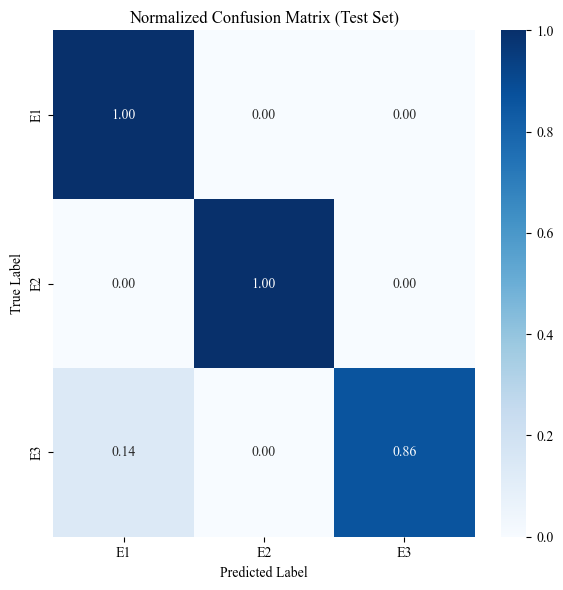

In [18]:
# 7. Final Evaluation on the Generalization Test Set

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize X_test with training scaler
X_test_flat = X_test.reshape(-1, n_sensors)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# Predict
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluation metrics
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
macro_prec = precision_score(y_true, y_pred, average='macro')
macro_rec = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')
kappa = cohen_kappa_score(y_true, y_pred)

# Print report
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro Precision: {macro_prec:.4f}")
print(f"Macro Recall: {macro_rec:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Summary and Final Model Saving

We summarize the LSTM model’s performance and persist the best version of the model for future inference or reproduction.  
The saved assets include:

- The trained LSTM model in Keras format (`.keras`)
- A structured JSON file summarizing final evaluation metrics and hyperparameters

These artifacts ensure reproducibility and allow the model to be easily reloaded for deployment or scientific reporting.


In [19]:
# 8. Summary of Results and Model Saving

import json

# Create results summary dictionary
lstm_summary = {
    "Test Accuracy": round(acc, 4),
    "Balanced Accuracy": round(bal_acc, 4),
    "Macro Precision": round(macro_prec, 4),
    "Macro Recall": round(macro_rec, 4),
    "Macro F1-Score": round(macro_f1, 4),
    "Cohen's Kappa": round(kappa, 4),
    "Model Type": "LSTM",
    "Window Size": WINDOW_SIZE,
    "Sensors": n_sensors,
    "Best Hyperparameters": best_hp.values
}

# Save model
os.makedirs("../models", exist_ok=True)
best_model.save("../models/lstm_model.keras")

# Save results summary
with open("../results/final_lstm_summary.json", "w") as f:
    json.dump(lstm_summary, f, indent=4)

print("✅ Final LSTM model and results summary saved to ../results/")


✅ Final LSTM model and results summary saved to ../results/


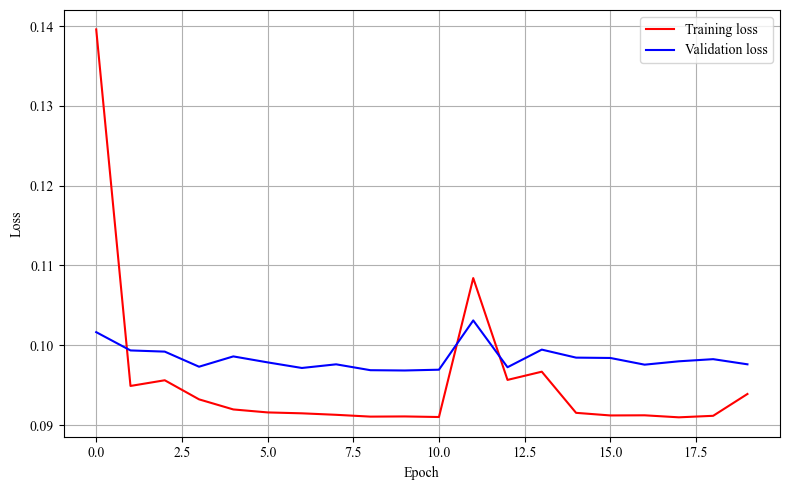

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# Gerar gráfico de treinamento
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training loss", color="red")
plt.plot(history.history["val_loss"], label="Validation loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
epochs = len(history.history["loss"])
train_acc = history.history["accuracy"][-1]
val_acc = history.history["val_accuracy"][-1]

print(f"Épocas: {epochs}")
print(f"Acurácia de Treinamento: {train_acc:.3f}")
print(f"Acurácia de Validação/Teste: {val_acc:.3f}")

In [ ]:
timesteps = X_train.shape[1]
print(f"Timesteps utilizados: {timesteps}")